# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

$-0.8 * ln(0.8) - 0.2 * ln(0.2) = 0.5$

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

$Q(R_m, j, t) = H(R_m) - 0 - 0 = 0.2 * 0.8 + 0.2 * 0.8 = 0.32$ при оптимальном разбиении

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

Берем просто среднее: $\frac{1 + 10 + 5 + 18 + 100 + 30 + 50 + 61 + 84 + 47}{10} = 40.6$

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [2]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [3]:
def Q_gini(l_data, r_data):
    probability_l = np.divide(list(l_data.groupby('target_vector')['feature_vector'].count()), len(l_data.index))
    probability_r = np.divide(list(r_data.groupby('target_vector')['feature_vector'].count()), len(r_data.index))
    Q = (len(l_data.index) * sum(probability_l * (np.ones_like(probability_l) - probability_l)) + \
    len(r_data.index) * sum(probability_r * (np.ones_like(probability_r) - probability_r))) / (len(l_data.index) + len(r_data.index))
    return Q

In [4]:
def Q_variance(l_data, r_data):
    return (len(l_data.index) * l_data.feature_vector.var() + len(r_data.index) * r_data.feature_vector.var()) / (len(l_data.index) + len(r_data.index))

In [5]:
def split_node(data_frame, t):
    if isinstance(t, float) or isinstance(t, int):
        data_temp_l = data_frame[data_frame.feature_vector <= t]
        data_temp_r = data_frame[data_frame.feature_vector > t]
    elif isinstance(t, str):
        data_temp_l_2 = data_frame[data_frame.feature_vector == t]
        data_temp_r_2 = data_frame[data_frame.feature_vector != t]
    return data_temp_l, data_temp_r

In [7]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
    
    data_frame = pd.DataFrame({'feature_vector': feature_vector, 'target_vector': target_vector})
    data_frame.sort_values('feature_vector')
    ginis = []
    variances = []
    
    if feature_type == 'categorical':
        thresholds = list(set(feature_vector))
    elif feature_type == 'real':
        feature_vector_sorted = sorted(feature_vector)
        feature_vector_useless = feature_vector_sorted[1:]
        del feature_vector_sorted[-1]
        thresholds = np.add(feature_vector_sorted, feature_vector_useless) / 2


    if task == 'classification':
        for t in thresholds:
            data_temp_l, data_temp_r = split_node(data_frame, t)
            ginis.append(Q_gini(data_temp_l, data_temp_r))
        gini_best = np.nanmin(ginis)
        min_index = ginis.index(gini_best)
        threshold_best = thresholds[min_index]
        return thresholds, ginis, threshold_best, gini_best
    elif task == 'regression':
        for t in thresholds:
            data_temp_l, data_temp_r = split_node(data_frame, t)
            variances.append(Q_variance(data_temp_l, data_temp_r))
        variance_best = np.nanmin(variances)
        min_index = variances.index(variance_best)
        threshold_best = thresholds[min_index]
        return thresholds, variances, threshold_best, variance_best

    
    
    
#СНАЧАЛА ЗАГРУЗИ ДАННЫЕ!!!
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

In [8]:
threshold_best

33.15885

In [9]:
variance_best

31.17663582597248

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [6]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

In [10]:
from matplotlib.pyplot import figure

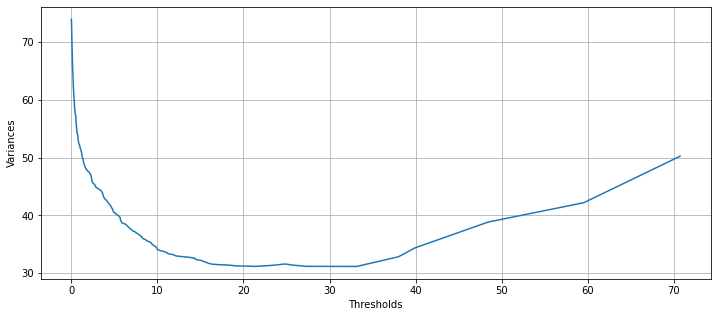

In [11]:
figure(figsize=(12, 5))
plt.plot(thresholds, variances)
plt.xlabel("Thresholds")
plt.ylabel("Variances")
plt.grid()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [12]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [13]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий остановки
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return 

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            if gini_best is None or gini < gini_best: #(!!!!!!!!!!!!!)
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = sub_X.iloc[:, feature_best] <= threshold_best # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
                    split = sub_X[:, feature_best] == threshold_best
                else:
                    raise ValueError

                    
        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return 

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        if node['type'] == 'terminal':
            return node['class']
        elif node['type'] == 'nonterminal':
            if x[node['feature_split']] == node['category_split']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
            
            

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X.itertuples():
            predicted.append(self._predict_node(list(x)[1:], self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [14]:
data_students = pd.read_csv("C:/Users/User/Майнор ИАД/2 семестр/Домашки/ДЗ_7-trees/students.csv")

In [15]:
data_students.head()

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0


In [16]:
columns = ['STG', 'SCG', 'STR', 'LPR', 'PEG']

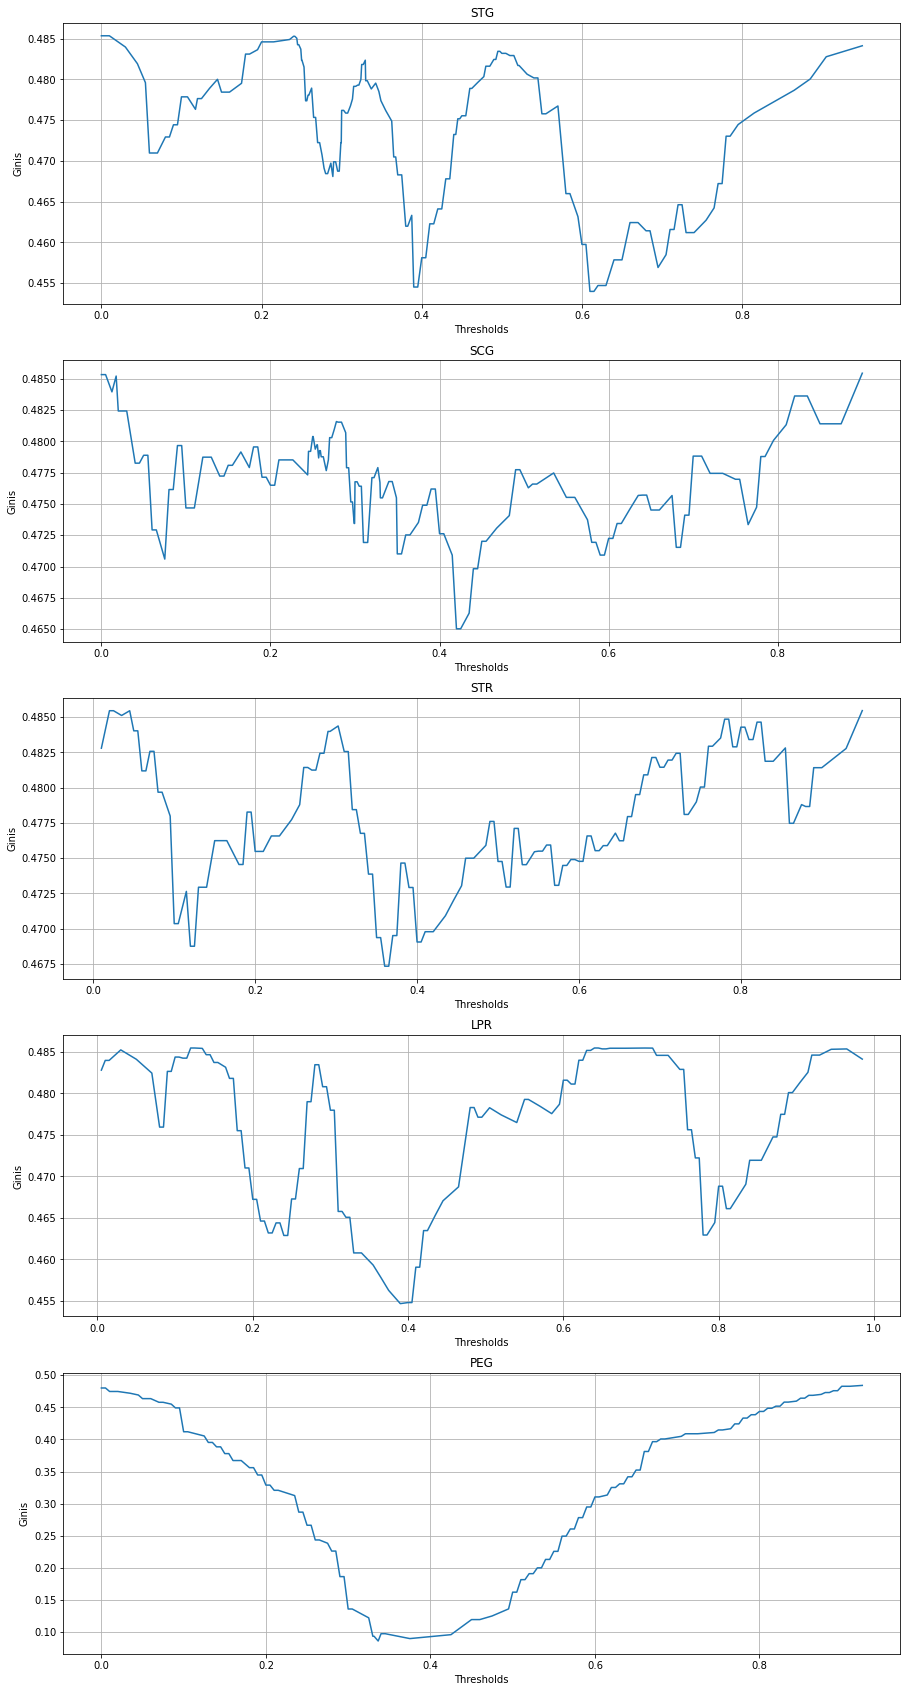

In [17]:
figure, axs = plt.subplots(5, figsize=(15, 30))
i = 0
for t in columns:
    thresholds, ginis, _, _ = find_best_split(data_students[t].to_numpy(), data_students.UNS, task="classification", feature_type="real")
    axs[i].plot(thresholds, ginis)
    axs[i].set_xlabel("Thresholds")
    axs[i].set_ylabel("Ginis")
    axs[i].set_title(t)
    axs[i].grid()
    i += 1

In [18]:
import seaborn as sns
from matplotlib.pyplot import figure

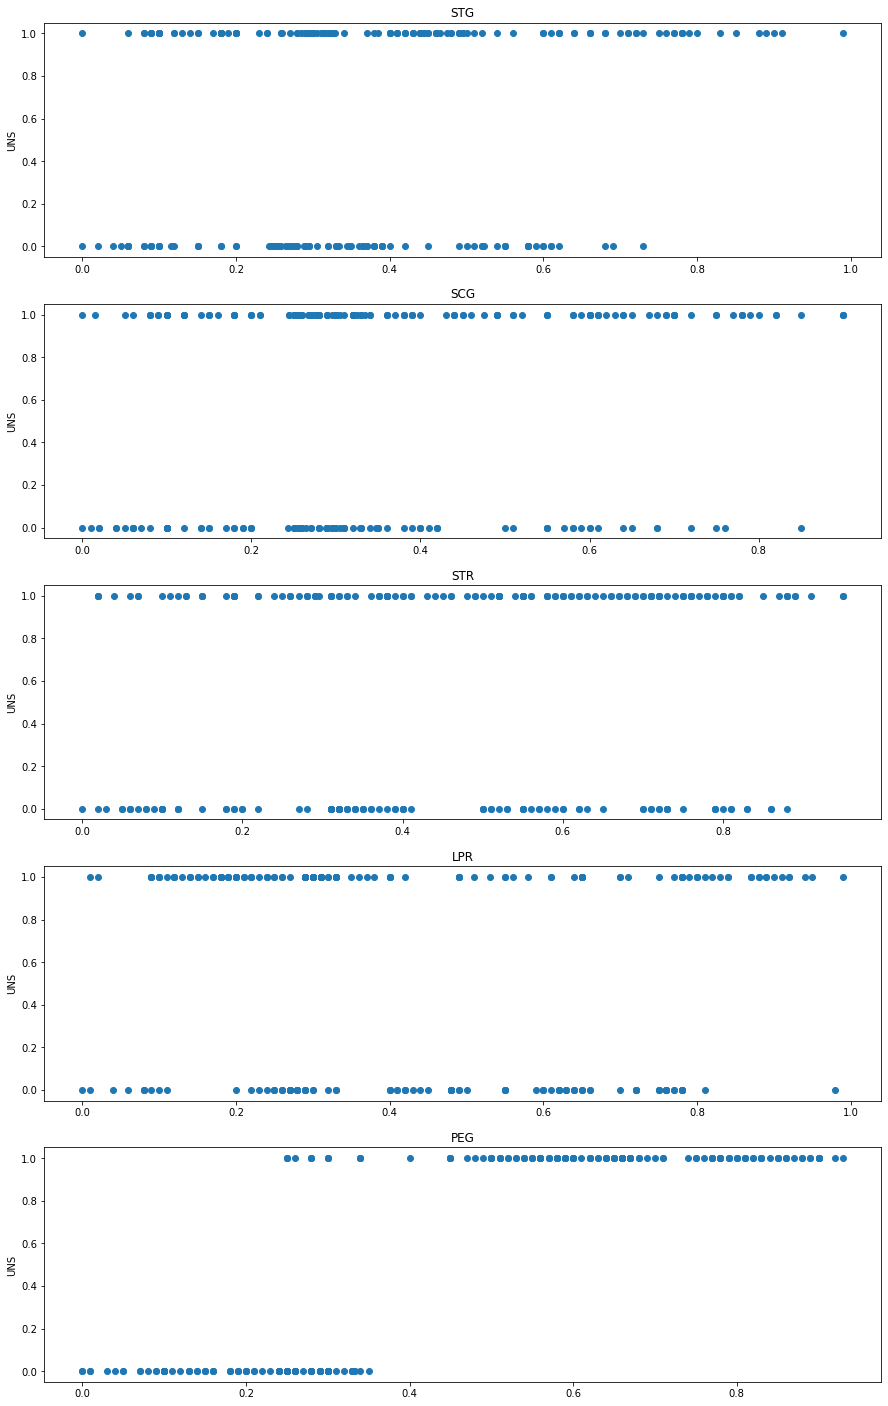

In [19]:
figure, axs = plt.subplots(5, figsize=(15, 25))
i = 0
for t in columns:
    #thresholds, ginis, _, _ = find_best_split(data_students[t].to_numpy(), data_students.UNS, task="regression", feature_type="real")
    #data_temp = pd.DataFrame(threshold)
    axs[i].scatter(y = data_students['UNS'], x = data_students[t])
    axs[i].set_title(t)
    axs[i].set_ylabel("UNS")
    i += 1

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

По признаку PEG, и да, он согласуется с визуальной оценкой.
Кривая должна иметь U-образный вид, т.е. сначала критерий Джини большой, потом уменьшается и достигает опитамльного значения, по которому выборка разбивается лучше всего(мы постепенно отделяем два класса друг от друга). Другими словами, знак производной должен быть постоянен.


Они ведут себя как-то хаотично; нет порядка, поэтому хорошее разбиение не получается.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [20]:
mushroom = pd.read_table("C:/Users/User/Майнор ИАД/2 семестр/Домашки/ДЗ_7-trees/agaricus-lepiota.data", delimiter=',')

In [21]:
mushroom.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
le = LabelEncoder()
for i in range(len(mushroom.columns)):
    mushroom.iloc[:, i:i+1] = le.fit_transform(np.ravel(mushroom.iloc[:, i:i+1])).reshape(-1, 1)

In [24]:
mushroom.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [25]:
X = mushroom.iloc[:, 1:]
y = mushroom.iloc[:, :1]

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
X_train.head()

,x,s,n,t,p.1,f,c,n.1,k,e,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
5873,5,3,5,1,5,1,0,0,10,0,...,2,2,7,0,2,2,0,7,1,6
2369,5,0,4,1,5,1,0,0,10,1,...,2,6,7,0,2,1,4,2,5,0
871,5,3,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,3,3
7019,3,0,8,0,5,1,1,0,2,0,...,1,7,7,0,2,2,4,7,2,1
2217,5,3,4,1,5,1,0,0,5,1,...,2,6,7,0,2,1,4,2,4,0


In [28]:
feature_types = ['categorical'] * len(X.columns)
dt_mine = DecisionTree(feature_types)
dt_mine.fit(X_train.values, y_train.iloc[:, 0].values)

In [29]:
y_test = y_test.astype('int')

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [32]:
accuracy_score(y_test, dt_mine.predict(X_test))

1.0

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [33]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [34]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

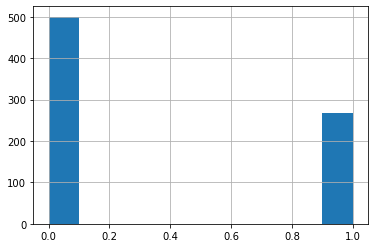

In [35]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [36]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]

In [37]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [38]:
y.head()

,Outcome
0,1
1,0
2,1
3,0
4,1


In [39]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
334,1,95,60,18,58,23.9,0.260,22
139,5,105,72,29,325,36.9,0.159,28
485,0,135,68,42,250,42.3,0.365,24
547,4,131,68,21,166,33.1,0.160,28
18,1,103,30,38,83,43.3,0.183,33


In [40]:
np.random.seed(42)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, train_size=0.7)

In [41]:
X_train_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
381,0,105,68,22,0,20.0,0.236,22
180,6,87,80,0,0,23.2,0.084,32
223,7,142,60,33,190,28.8,0.687,61
557,8,110,76,0,0,27.8,0.237,58
138,0,129,80,0,0,31.2,0.703,29


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [42]:
from sklearn.metrics import f1_score
from operator import itemgetter

In [43]:
np.random.seed(42)
max_depth_array = range(2, 20)
min_samples_leaf_array = range(1, 20)
f1 = []
for i in max_depth_array:
    for j in min_samples_leaf_array:
        dt = DecisionTreeClassifier(max_depth = i, min_samples_leaf = j)
        dt.fit(X_train_train, y_train_train)
        f1.append((i, j, f1_score(y_train_val, dt.predict(X_train_val))))
        print('Max depth =', i, ',min samples leaf = ', j, ',f1 score = ', f1_score(y_train_val, dt.predict(X_train_val)))

Max depth = 2 ,min samples leaf =  1 ,f1 score =  0.425
Max depth = 2 ,min samples leaf =  2 ,f1 score =  0.4444444444444444
Max depth = 2 ,min samples leaf =  3 ,f1 score =  0.4444444444444444
Max depth = 2 ,min samples leaf =  4 ,f1 score =  0.4444444444444444
Max depth = 2 ,min samples leaf =  5 ,f1 score =  0.4444444444444444
Max depth = 2 ,min samples leaf =  6 ,f1 score =  0.4444444444444444
Max depth = 2 ,min samples leaf =  7 ,f1 score =  0.4444444444444444
Max depth = 2 ,min samples leaf =  8 ,f1 score =  0.4444444444444444
Max depth = 2 ,min samples leaf =  9 ,f1 score =  0.4444444444444444
Max depth = 2 ,min samples leaf =  10 ,f1 score =  0.4444444444444444
Max depth = 2 ,min samples leaf =  11 ,f1 score =  0.4444444444444444
Max depth = 2 ,min samples leaf =  12 ,f1 score =  0.4444444444444444
Max depth = 2 ,min samples leaf =  13 ,f1 score =  0.4444444444444444
Max depth = 2 ,min samples leaf =  14 ,f1 score =  0.4444444444444444
Max depth = 2 ,min samples leaf =  15 ,f1 

Max depth = 9 ,min samples leaf =  5 ,f1 score =  0.6017699115044246
Max depth = 9 ,min samples leaf =  6 ,f1 score =  0.6037735849056604
Max depth = 9 ,min samples leaf =  7 ,f1 score =  0.6213592233009709
Max depth = 9 ,min samples leaf =  8 ,f1 score =  0.594059405940594
Max depth = 9 ,min samples leaf =  9 ,f1 score =  0.5981308411214952
Max depth = 9 ,min samples leaf =  10 ,f1 score =  0.5858585858585859
Max depth = 9 ,min samples leaf =  11 ,f1 score =  0.6138613861386139
Max depth = 9 ,min samples leaf =  12 ,f1 score =  0.6138613861386139
Max depth = 9 ,min samples leaf =  13 ,f1 score =  0.6274509803921569
Max depth = 9 ,min samples leaf =  14 ,f1 score =  0.5652173913043479
Max depth = 9 ,min samples leaf =  15 ,f1 score =  0.5617977528089887
Max depth = 9 ,min samples leaf =  16 ,f1 score =  0.5617977528089887
Max depth = 9 ,min samples leaf =  17 ,f1 score =  0.5617977528089887
Max depth = 9 ,min samples leaf =  18 ,f1 score =  0.5617977528089887
Max depth = 9 ,min samples

Max depth = 16 ,min samples leaf =  8 ,f1 score =  0.5656565656565657
Max depth = 16 ,min samples leaf =  9 ,f1 score =  0.5981308411214952
Max depth = 16 ,min samples leaf =  10 ,f1 score =  0.5858585858585859
Max depth = 16 ,min samples leaf =  11 ,f1 score =  0.6138613861386139
Max depth = 16 ,min samples leaf =  12 ,f1 score =  0.6138613861386139
Max depth = 16 ,min samples leaf =  13 ,f1 score =  0.6274509803921569
Max depth = 16 ,min samples leaf =  14 ,f1 score =  0.5652173913043479
Max depth = 16 ,min samples leaf =  15 ,f1 score =  0.5617977528089887
Max depth = 16 ,min samples leaf =  16 ,f1 score =  0.5617977528089887
Max depth = 16 ,min samples leaf =  17 ,f1 score =  0.5617977528089887
Max depth = 16 ,min samples leaf =  18 ,f1 score =  0.5617977528089887
Max depth = 16 ,min samples leaf =  19 ,f1 score =  0.5617977528089887
Max depth = 17 ,min samples leaf =  1 ,f1 score =  0.6037735849056604
Max depth = 17 ,min samples leaf =  2 ,f1 score =  0.6407766990291263
Max depth 

In [44]:
max(f1, key=itemgetter(2))

(7, 7, 0.7142857142857143)

У меня получилось, что наилучшее качество достигается при max_depth = 7 и min_samples_leaf = 7

In [45]:
np.random.seed(42)
dt_best = DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 7)
dt_best.fit(X_train, y_train)
print("Accuracy =", accuracy_score(y_test, dt_best.predict(X_test)))
print("Precision =", precision_score(y_test, dt_best.predict(X_test)))
print("Recall =", recall_score(y_test, dt_best.predict(X_test)))
print("AUC-ROC =", roc_auc_score(y_test, dt_best.predict(X_test)))

Accuracy = 0.696969696969697
Precision = 0.5555555555555556
Recall = 0.625
AUC-ROC = 0.6800496688741722


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [46]:
np.random.seed(42)
bc = BaggingClassifier(n_estimators = 50)
bc.fit(X_train, y_train)

print("Accuracy =", accuracy_score(y_test, bc.predict(X_test)))
print("Precision =", precision_score(y_test, bc.predict(X_test)))
print("Recall =", recall_score(y_test, bc.predict(X_test)))
print("AUC-ROC =", roc_auc_score(y_test, bc.predict(X_test)))

Accuracy = 0.7489177489177489
Precision = 0.6309523809523809
Recall = 0.6625
AUC-ROC = 0.7286009933774835


C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [47]:
from sklearn.model_selection import cross_val_score

In [48]:
np.random.seed(42)
max_depth_array = range(2, 20)
min_samples_leaf_array = range(1, 20)
f1_random = []
for i in max_depth_array:
    for j in min_samples_leaf_array:
        rf = RandomForestClassifier(max_depth = i, min_samples_leaf = j, n_estimators = 50)
        score = cross_val_score(rf, X_train, np.ravel(y_train), scoring='f1')
        f1_random.append((i, j, score.mean()))
        print('Max depth =', i, ',min samples leaf = ', j, ',f1 score = ', score.mean())

Max depth = 2 ,min samples leaf =  1 ,f1 score =  0.5397492328055478
Max depth = 2 ,min samples leaf =  2 ,f1 score =  0.5203602876924112
Max depth = 2 ,min samples leaf =  3 ,f1 score =  0.4981611534185886
Max depth = 2 ,min samples leaf =  4 ,f1 score =  0.5127270029334886
Max depth = 2 ,min samples leaf =  5 ,f1 score =  0.5491541790749382
Max depth = 2 ,min samples leaf =  6 ,f1 score =  0.5451137186730407
Max depth = 2 ,min samples leaf =  7 ,f1 score =  0.5102558923692345
Max depth = 2 ,min samples leaf =  8 ,f1 score =  0.5269373697090547
Max depth = 2 ,min samples leaf =  9 ,f1 score =  0.5235002616880629
Max depth = 2 ,min samples leaf =  10 ,f1 score =  0.5330705749409308
Max depth = 2 ,min samples leaf =  11 ,f1 score =  0.5277656405163853
Max depth = 2 ,min samples leaf =  12 ,f1 score =  0.5316331531572784
Max depth = 2 ,min samples leaf =  13 ,f1 score =  0.5455206728299948
Max depth = 2 ,min samples leaf =  14 ,f1 score =  0.5340472447735053
Max depth = 2 ,min samples le

Max depth = 8 ,min samples leaf =  6 ,f1 score =  0.6067943109608025
Max depth = 8 ,min samples leaf =  7 ,f1 score =  0.6190338582271783
Max depth = 8 ,min samples leaf =  8 ,f1 score =  0.6285253483218864
Max depth = 8 ,min samples leaf =  9 ,f1 score =  0.6318900580760164
Max depth = 8 ,min samples leaf =  10 ,f1 score =  0.6263699142387666
Max depth = 8 ,min samples leaf =  11 ,f1 score =  0.5790992403517803
Max depth = 8 ,min samples leaf =  12 ,f1 score =  0.5993722390141827
Max depth = 8 ,min samples leaf =  13 ,f1 score =  0.6119773918901766
Max depth = 8 ,min samples leaf =  14 ,f1 score =  0.5921993170763662
Max depth = 8 ,min samples leaf =  15 ,f1 score =  0.6085912698412698
Max depth = 8 ,min samples leaf =  16 ,f1 score =  0.5973082609302806
Max depth = 8 ,min samples leaf =  17 ,f1 score =  0.5972278535640605
Max depth = 8 ,min samples leaf =  18 ,f1 score =  0.6076926855998337
Max depth = 8 ,min samples leaf =  19 ,f1 score =  0.6061374083707978
Max depth = 9 ,min sampl

Max depth = 14 ,min samples leaf =  9 ,f1 score =  0.6237234409449299
Max depth = 14 ,min samples leaf =  10 ,f1 score =  0.6148211451158192
Max depth = 14 ,min samples leaf =  11 ,f1 score =  0.59184095183625
Max depth = 14 ,min samples leaf =  12 ,f1 score =  0.632363335589142
Max depth = 14 ,min samples leaf =  13 ,f1 score =  0.6238734754448592
Max depth = 14 ,min samples leaf =  14 ,f1 score =  0.6050267214144596
Max depth = 14 ,min samples leaf =  15 ,f1 score =  0.6013796516671486
Max depth = 14 ,min samples leaf =  16 ,f1 score =  0.5922711896482389
Max depth = 14 ,min samples leaf =  17 ,f1 score =  0.6094328494888196
Max depth = 14 ,min samples leaf =  18 ,f1 score =  0.5953303538123272
Max depth = 14 ,min samples leaf =  19 ,f1 score =  0.5770596422648662
Max depth = 15 ,min samples leaf =  1 ,f1 score =  0.6261958477617491
Max depth = 15 ,min samples leaf =  2 ,f1 score =  0.636076100722881
Max depth = 15 ,min samples leaf =  3 ,f1 score =  0.6403661914829779
Max depth = 15

In [49]:
max(f1_random, key=itemgetter(2))

(18, 2, 0.6589837711755521)

In [50]:
np.random.seed(42)
rf_best = RandomForestClassifier(max_depth = 18, min_samples_leaf = 2, n_estimators = 50)
rf_best.fit(X_train, np.ravel(y_train))

print("Accuracy =", accuracy_score(y_test, rf_best.predict(X_test)))
print("Precision =", precision_score(y_test, rf_best.predict(X_test)))
print("Recall =", recall_score(y_test, rf_best.predict(X_test)))
print("AUC-ROC =", roc_auc_score(y_test, rf_best.predict(X_test)))

Accuracy = 0.7619047619047619
Precision = 0.6582278481012658
Recall = 0.65
AUC-ROC = 0.7355960264900662


Random Forest лучше всех!

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [51]:
from matplotlib.pyplot import figure

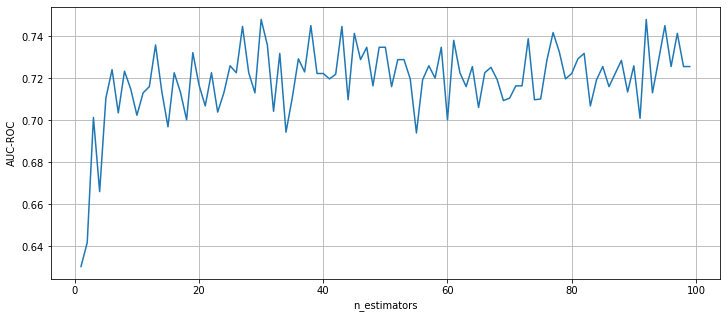

In [52]:
np.random.seed(42)
n_estimators_array = range(1, 100)
auc_roc_array = []
for i in n_estimators_array:
    rf = RandomForestClassifier(max_depth = 18, min_samples_leaf = 2, n_estimators = i)
    rf.fit(X_train, np.ravel(y_train))
    auc_roc_array.append(roc_auc_score(y_test, rf.predict(X_test)))

figure(figsize=(12, 5))
plt.plot(n_estimators_array, auc_roc_array)
plt.xlabel('n_estimators')
plt.ylabel('AUC-ROC')
plt.grid()

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [53]:
rf_best.feature_importances_

array([0.08327787, 0.30694171, 0.08286107, 0.05874031, 0.06870865,
       0.16289862, 0.0911394 , 0.14543238])

<BarContainer object of 8 artists>

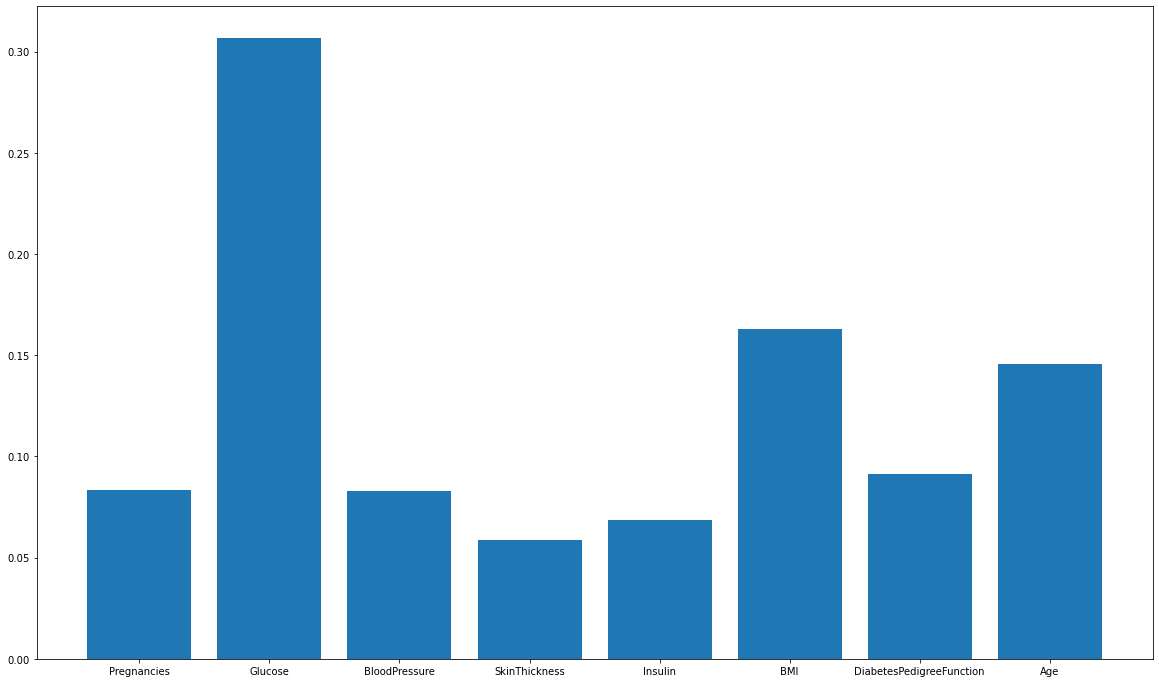

In [54]:
plt.figure(figsize = (20, 12))
plt.bar(X.columns, rf_best.feature_importances_)

Самый важный признак - количество глюкозы